# **Prepare notebook**

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks


In [ ]:
import numpy as np
import os
import tensorflow as tf
import keras as tfk
from keras.layers import Input, Dense, Dropout, Lambda
from keras import layers as tfkl
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
seed = 43

print(f"Tensorflow version -> {tf.__version__}")
print(f"Keras version -> {tfk.__version__}")


Tensorflow version -> 2.17.1
Keras version -> 3.5.0


In [ ]:
!pip install keras-cv
import keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 59.3 MB/s eta 0:00:00


# **Load Data**

I load the data from the dataset to carry out the first attempts at transference learning, then another loading function will be used

In [ ]:
#Load data from datasetWithout, datasetWithout doesn't have outlier
data = np.load('datasetWithout.npz')
x_train = data['x_train']
y_train = data['y_train']
x_train2 = data['x_train']
y_train2 = data['y_train']
x_train_normal = data['x_train']
y_train_normal = data['y_train']

In [ ]:
#Normalized image and transform label in categorical form
x_train = x_train / 255.0
y_train = to_categorical(y_train).astype('float32')
x_train2 = x_train2 / 255.0
y_train2 = to_categorical(y_train2).astype('float32')
x_train_normal = x_train_normal / 255.0
y_train_normal = to_categorical(y_train_normal).astype('float32')

# **Class weights**

I prepare the weights of each class, activated only if it is necessary

In [ ]:
#I find the weights of the classes
if len(y_train.shape) > 1:
    y_train_m = np.argmax(y_train, axis=1)

#Count the occurrences for each class.
class_counts = np.bincount(y_train_m)
total_samples = len(y_train_m)

# Calculates weights inversely proportional to frequency
class_weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts)}

# **Augmentation**

I prepare two different types of augmentation, one much heavier than the other. In this way I have different degrees of augmentation

In [ ]:
#First type augmentation, random augmentation
data_augmentation = tfk.Sequential(
[
    keras_cv.layers.RandAugment(
        value_range=(0.0, 1.0),
        augmentations_per_image=4,
        magnitude_stddev=0.4,
        rate=0.5
    )
])

In [ ]:
#Second type augmentation, also random but with limited set of augmentation
data_augmentation2 = keras_cv.layers.RandomAugmentationPipeline(
    layers=[
        keras_cv.layers.RandomTranslation(height_factor=0.5, width_factor=0.5, seed=seed),
        keras_cv.layers.RandomTranslation(height_factor=0.5, width_factor=0.5, seed=seed),
        keras_cv.layers.RandomContrast(factor=0.8, value_range=(0.0, 1.0), seed=seed),
        keras_cv.layers.RandomHue(factor=(0.8,1.0), value_range=(0.0, 1.0), seed=seed),
        keras_cv.layers.RandomSharpness(factor = 1, value_range=(0.0, 1.0), seed=seed),
        keras_cv.layers.RandomColorDegeneration(factor = 1, seed=seed),
        keras_cv.layers.ChannelShuffle(groups=3, seed=seed),
        keras_cv.layers.RandomChannelShift(factor=0.8, value_range=(0.0, 1.0), channels=3, seed=seed),
        keras_cv.layers.Solarization(value_range = (0.0, 1.0), seed=seed),
        keras_cv.layers.RandomBrightness(factor=0.3, value_range=(0.0, 1.0), seed=seed),
        keras_cv.layers.GridMask(ratio_factor=(0, 0.4), rotation_factor=0.2, fill_mode="constant", fill_value=0.0, seed=seed)
    ],
    seed=12,
    augmentations_per_image=6
)

In [ ]:
#dataset duplication and transformation to tensors
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(512)
train_dataset2 = tf.data.Dataset.from_tensor_slices((x_train2, y_train2)).batch(512)

In [ ]:
#First dataset augmentation
def augment_images(image, label):
    image = data_augmentation(image)
    return image, label
#Map operation in the tensor
train_dataset = train_dataset.map(augment_images, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
#Second dataset augmentation
def augment_images2(image, label):
    image = data_augmentation(image)
    return image, label
train_dataset2 = train_dataset2.map(augment_images2, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset2 = train_dataset2.prefetch(tf.data.AUTOTUNE)

In [ ]:
#Dataset recomposition
x_train, y_train = [], []
for batch in train_dataset:
    images = batch[0].numpy()
    labels = batch[1].numpy()
    x_train.append(images)
    y_train.append(labels)
x_train = np.concatenate(x_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

del train_dataset

In [ ]:
x_train2, y_train2 = [], []
for batch in train_dataset2:
    images2 = batch[0].numpy()
    labels2 = batch[1].numpy()
    x_train2.append(images2)
    y_train2.append(labels2)
x_train2 = np.concatenate(x_train2, axis=0)
y_train2 = np.concatenate(y_train2, axis=0)

del train_dataset2

In [ ]:
#Contatenation of two dataset with two different augmentation
#I also add images without augmentation so as not to lose important features
x_train = np.concatenate((x_train, x_train2, x_train_normal), axis=0)
y_train = np.concatenate((y_train, y_train2, y_train_normal), axis=0)

In [ ]:
indices = np.random.permutation(len(x_train))
x_train = x_train[indices]
y_train = y_train[indices]

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.35, stratify=y_train)

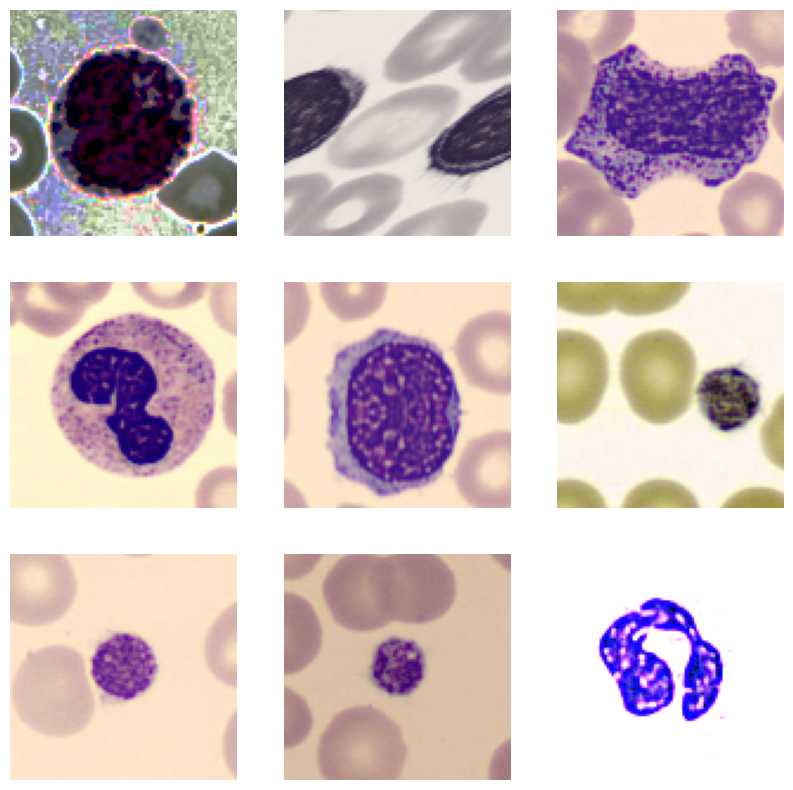

In [ ]:
#Check the result
plt.figure(figsize=(10, 10))
for i in range(9):
   plt.subplot(3, 3, i + 1)
   plt.imshow(x_train[i+7777])
   plt.axis("off")
plt.show()

# ***Transfer Model with val_precision***

Loading inpectionNet50 for the first attempt at transfer learnig

In [ ]:
input_shape = (96, 96, 3)
output_shape = 8
learning_rate = 0.005
batch_size = 32
epochs = 1000

In [ ]:
# @title InceptionResNetV2 improt
NAS = tfk.applications.InceptionResNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    pooling='avg',
    #include_preprocessing = True
)

for layer in NAS.layers:
    layer.trainable = False

# INPUT layer
inputs = tfk.Input(shape=input_shape)

x = NAS(inputs)  # Pass augmented data through EfficientNetB4

# Dense layers (head of the model)
x = tfkl.Dropout(0.3, name='dropout')(x)  # Dropout per regolarizzazione
x = tfkl.Dense(256, name="dense1")(x)  # Riduci la regolarizzazione
x = tfkl.BatchNormalization()(x)
x = tfkl.Activation("relu")(x)
x = tfkl.Dropout(0.4, name='dropout1')(x)  # Dropout moderato
outputs = tfkl.Dense(output_shape, activation='softmax', name="output")(x)  # Final layer

# Compile the model
tl_model = tfk.Model(inputs=inputs, outputs=outputs)
tl_model.compile(
    loss=tfk.losses.CategoricalCrossentropy(),
    optimizer=tfk.optimizers.Adam(learning_rate=1e-4),  # Usa Adam con LR moderato
    metrics = [tfk.metrics.Precision()]
)
# Model summary
tl_model.summary(expand_nested=True)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_resnet_v2 (Functional)     │ (None, 1536)                │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer_5 (InputLayer)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv2d_406 (Conv2D)             │ (None, 47, 47, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ batch_normalization_408         │ (None, 47, 47, 32)          │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ activation_408 (Activation)     │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv2d_407 (Conv2D)             │ (None, 45, 45, 32)          │           9,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ batch_normalization_409         │ (None, 45, 45, 32)          │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ activation_409 (Activation)     │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv2d_408 (Conv2D)             │ (None, 45, 45, 64)          │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ batch_normalization_410         │ (None, 45, 45, 64)          │             192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ activation_410 (Activation)     │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ max_pooling2d_8 (MaxPooling2D)  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv2d_409 (Conv2D)             │ (None, 22, 22, 80)          │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ batch_normalization_411         │ (None, 22, 22, 80)          │             240 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ activation_411 (Activation)     │ (None, 22, 22, 80)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv2d_410 (Conv2D)             │ (None, 20, 20, 192)         │         138,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ batch_normalization_412         │ (None, 20, 20, 192)         │             576 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ activation_412 (Activation)     │ (None, 20, 20, 192)         │              

 Total params: 54,733,288 (208.79 MB)

 Trainable params: 396,040 (1.51 MB)

 Non-trainable params: 54,337,248 (207.28 MB)

In [ ]:
#eraly stopping setup to avoid overfitting
patience = 15
stopper = tfk.callbacks.EarlyStopping(
    monitor="val_precision",
    min_delta=0,
    patience=patience,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)


In [ ]:
#train of the model
history = tl_model.fit(
    x=x_train,
    y=y_train,
    batch_size = batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=stopper,
    class_weight=class_weights
).history

tl_model.save("InceptionResNetV2.keras")

Epoch 1/1000
364/365 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.2177 - precision: 0.7750
Epoch 1: val_precision improved from -inf to 0.75031, saving model to TT.keras
365/365 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - loss: 1.2178 - precision: 0.7750 - val_loss: 1.3658 - val_precision: 0.7503
Epoch 2/1000
364/365 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.2222 - precision: 0.7763
Epoch 2: val_precision improved from 0.75031 to 0.75425, saving model to TT.keras
365/365 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - loss: 1.2222 - precision: 0.7763 - val_loss: 1.3620 - val_precision: 0.7543
Epoch 3/1000
364/365 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.2213 - precision: 0.7791
Epoch 3: val_precision did not improve from 0.75425
365/365 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 1.2214 - precision: 0.7791 - val_loss: 1.3597 - val_precision: 0.7524
Epoch 4/1000
364/365 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.2292 - precision: 0.7736
Epoch 4: val_precision did not improve from 0.75425
365/365 ━━━━

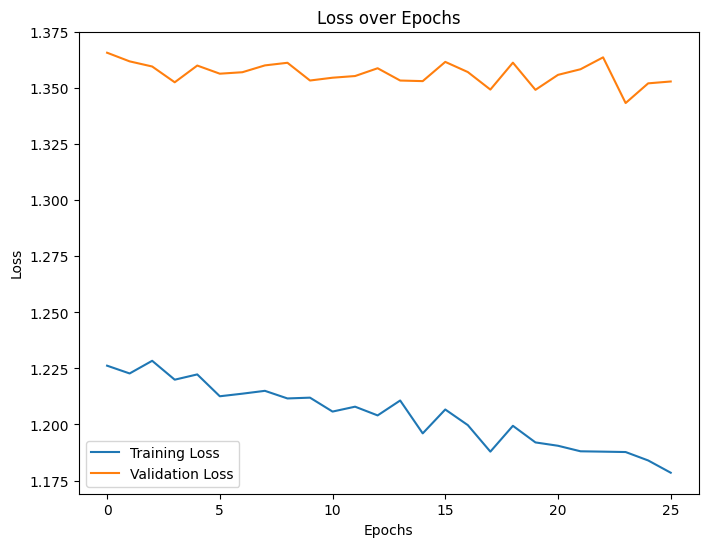

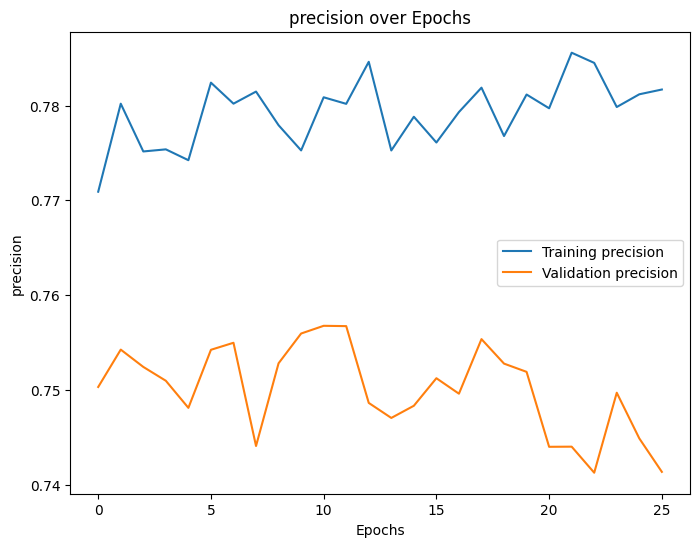

In [ ]:
# Data estraction from history
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['precision']
val_accuracy = history['val_precision']

# Creation of the graph
plt.figure(figsize=(8, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(accuracy, label='Training precision')
plt.plot(val_accuracy, label='Validation precision')
plt.title('precision over Epochs')
plt.xlabel('Epochs')
plt.ylabel('precision')
plt.legend()
plt.show()

393/393 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step


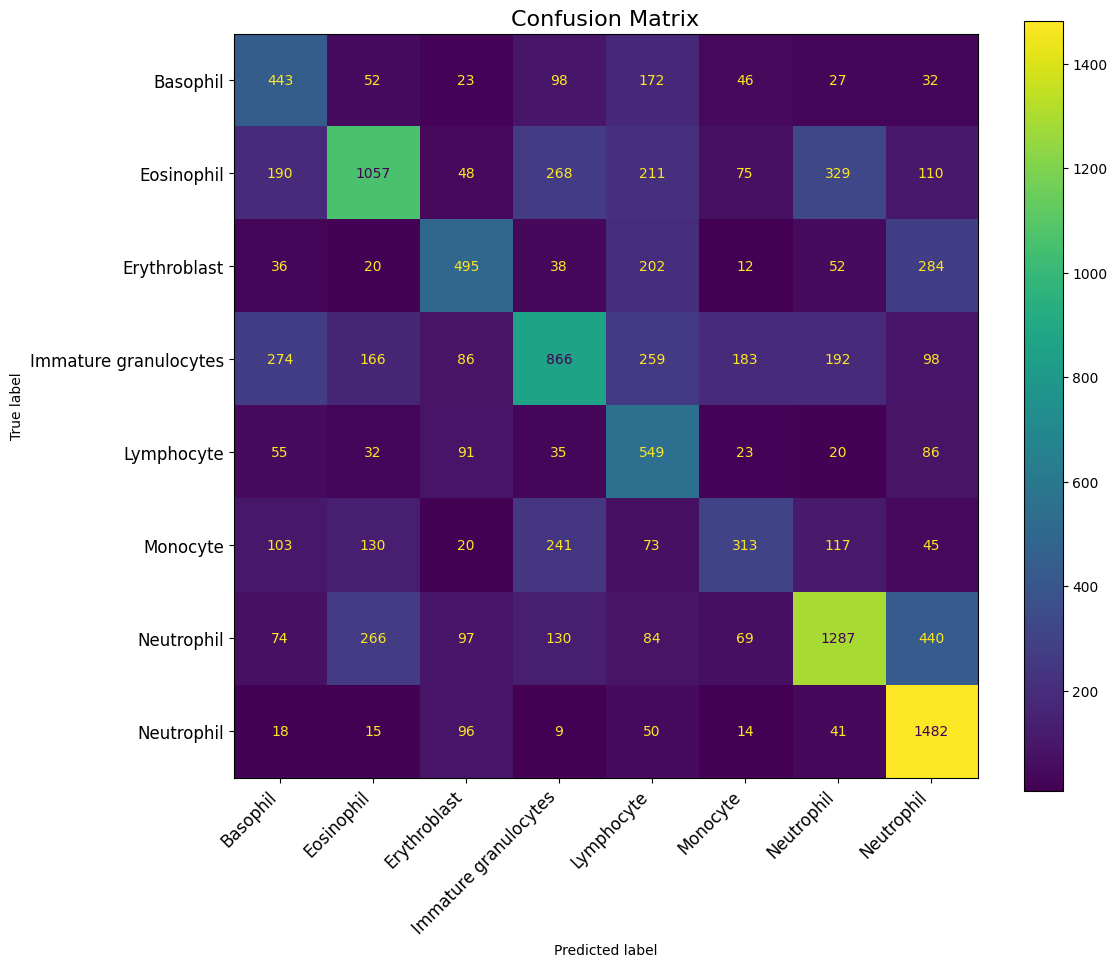

Accuracy: 51.73%


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

#Import model from drive repository
model = tfk.models.load_model('InceptionResNetV2.keras')

#Make prediction on a new dataset
y_pred = model.predict(x_val)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_val.argmax(axis=1)


cm = confusion_matrix(y_true, y_pred_classes)
class_labels = ["Basophil", "Eosinophil", "Erythroblast",
                "Immature granulocytes", "Lymphocyte",
                "Monocyte", "Neutrophil", "Platelet"]

# Plot the confusion matrix of prediction
fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap="viridis", ax=ax)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

#Print also accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy:.2%}")

# **Tuning learning  - Val_presion model**

I also perform tuning operations of the transfer model. Attempt to use precision for early stopping



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

#I load the model on which I want to perform fine tuning
ft_model = tfk.models.load_model('InceptionResNetV2.keras')

#Set all trainable, avoid bugs
ft_model.get_layer('inception_resnet_v2').trainable = True

#Set all non trainable
for layer in ft_model.get_layer('inception_resnet_v2').layers:
    layer.trainable = False

#Set trainable only convolution layer
for i, layer in enumerate(ft_model.get_layer('inception_resnet_v2').layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True

In [ ]:
#Compilation of the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy'])

In [ ]:
patience = 15

early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

callbacks = [early_stopping]

In [ ]:
history = ft_model.fit(
    x=x_train,
    y=y_train,
    batch_size = 64,
    epochs=1000,
    validation_data=(x_val, y_val),
    callbacks=callbacks
).history

ft_model.save("TuningNAS.keras")

Epoch 1/1000
365/365 ━━━━━━━━━━━━━━━━━━━━ 155s 223ms/step - accuracy: 0.8035 - loss: 0.5805 - val_accuracy: 0.8858 - val_loss: 0.3301
Epoch 2/1000
365/365 ━━━━━━━━━━━━━━━━━━━━ 30s 81ms/step - accuracy: 0.9325 - loss: 0.2056 - val_accuracy: 0.9092 - val_loss: 0.2765
Epoch 3/1000
365/365 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - accuracy: 0.9544 - loss: 0.1342 - val_accuracy: 0.9281 - val_loss: 0.2221
Epoch 4/1000
365/365 ━━━━━━━━━━━━━━━━━━━━ 29s 78ms/step - accuracy: 0.9743 - loss: 0.0751 - val_accuracy: 0.8985 - val_loss: 0.3566
Epoch 5/1000
365/365 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - accuracy: 0.9626 - loss: 0.1106 - val_accuracy: 0.9248 - val_loss: 0.2714
Epoch 6/1000
365/365 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - accuracy: 0.9814 - loss: 0.0581 - val_accuracy: 0.9362 - val_loss: 0.2353
Epoch 7/1000
365/365 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - accuracy: 0.9851 - loss: 0.0463 - val_accuracy: 0.9426 - val_loss: 0.2111
Epoch 8/1000
365/365 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - accuracy: 0.9879

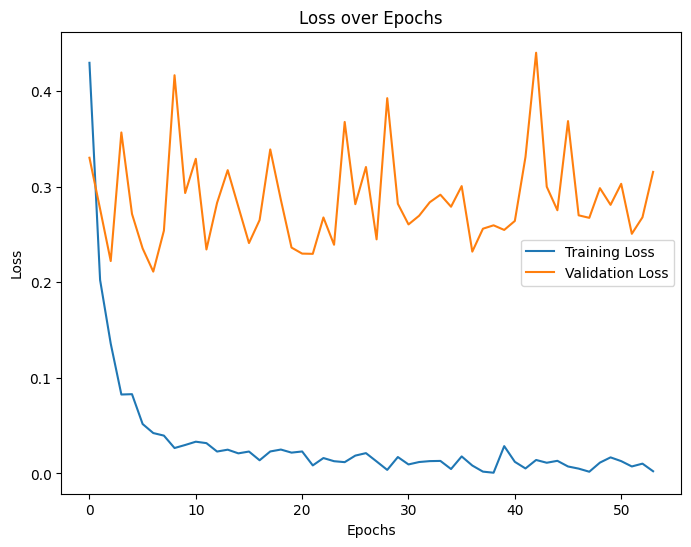

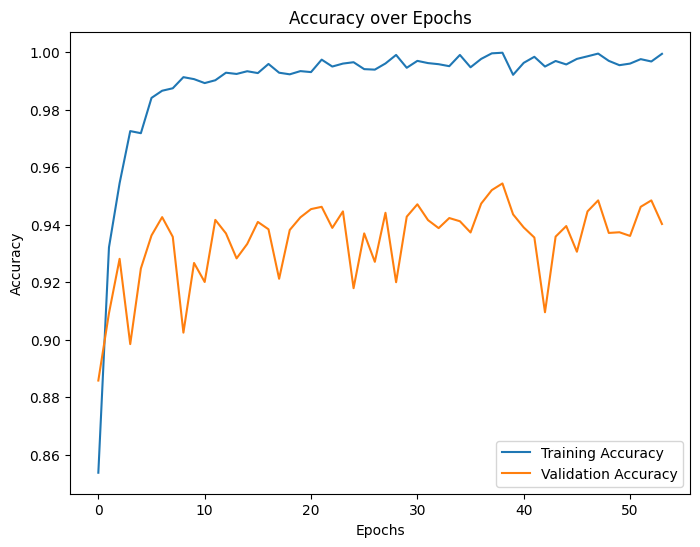

In [ ]:
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

729/729 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step


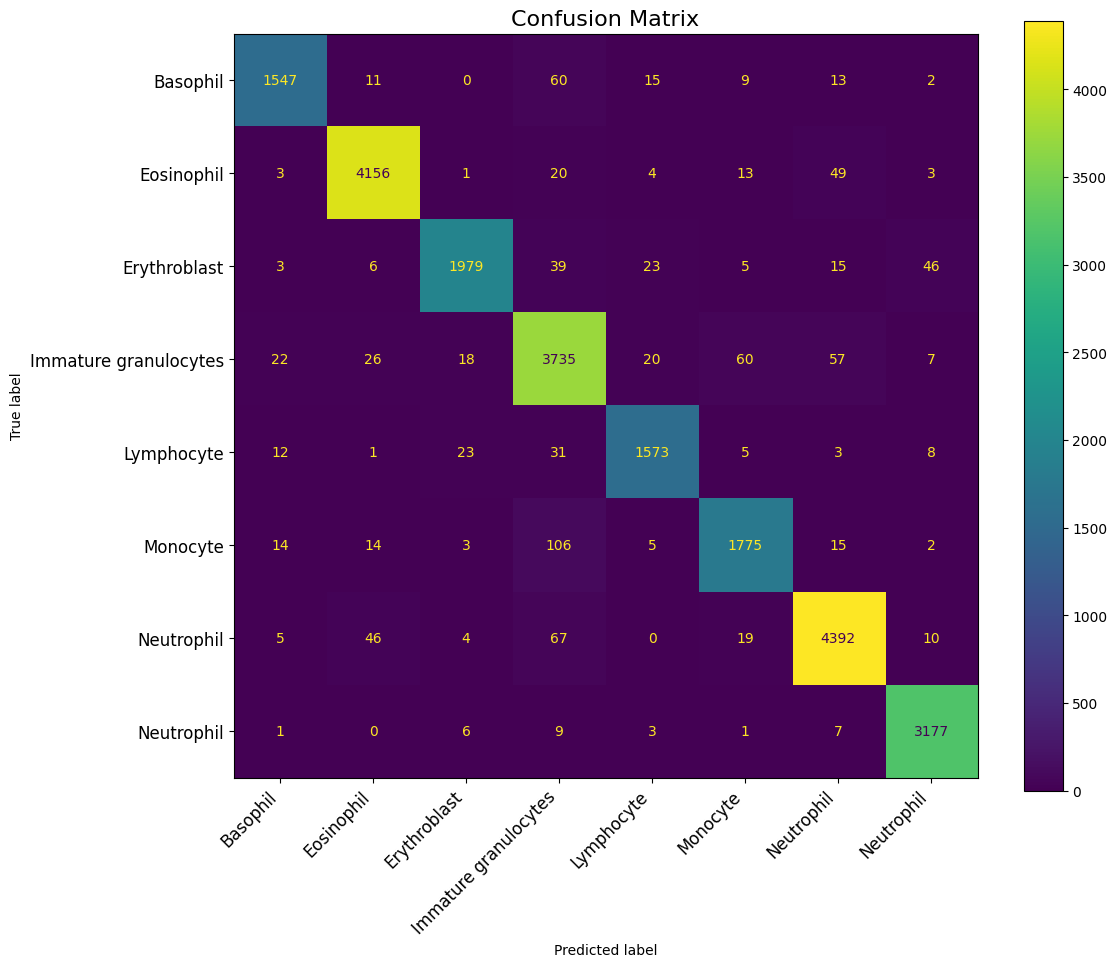

Accuracy: 95.84%


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

ft_model = tfk.models.load_model('Tuning2.keras')

y_pred = ft_model.predict(x_train)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_train.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
class_labels = ["Basophil", "Eosinophil", "Erythroblast",
                "Immature granulocytes", "Lymphocyte",
                "Monocyte", "Neutrophil", "Neutrophil"]

# Visualizzazione con dimensioni e rotazioni personalizzate
fig, ax = plt.subplots(figsize=(12, 10))  # Aumenta le dimensioni della figura
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap="viridis", ax=ax)
plt.xticks(rotation=45, ha="right", fontsize=12)  # Rotazione e dimensione carattere delle etichette
plt.yticks(fontsize=12)  # Dimensione carattere etichette asse y
plt.title("Confusion Matrix", fontsize=16)
plt.show()

accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy:.2%}")

# **Tuning learning  - val_accuracy model**

Also conducted tuning with early stopping based on accuracy


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

ft_model = tfk.models.load_model('InceptionResNetV1.keras')

ft_model.get_layer('inception_resnet_v2').trainable = True

for layer in ft_model.get_layer('inception_resnet_v2').layers:
    layer.trainable = False

for i, layer in enumerate(ft_model.get_layer('inception_resnet_v2').layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True

In [ ]:
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy'])

In [ ]:
patience = 15

early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

callbacks = [early_stopping]

In [ ]:
history = ft_model.fit(
    x=x_train,
    y=y_train,
    batch_size = 64,
    epochs=1000,
    validation_data=(x_val, y_val),
    callbacks=callbacks
).history

ft_model.save("TuningNAS.keras")

Epoch 1/1000
365/365 ━━━━━━━━━━━━━━━━━━━━ 148s 210ms/step - accuracy: 0.8100 - loss: 0.5592 - val_accuracy: 0.9041 - val_loss: 0.2809
Epoch 2/1000
365/365 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - accuracy: 0.9226 - loss: 0.2277 - val_accuracy: 0.9248 - val_loss: 0.2334
Epoch 3/1000
365/365 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - accuracy: 0.9561 - loss: 0.1370 - val_accuracy: 0.9254 - val_loss: 0.2467
Epoch 4/1000
365/365 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - accuracy: 0.9717 - loss: 0.0861 - val_accuracy: 0.9304 - val_loss: 0.2351
Epoch 5/1000
365/365 ━━━━━━━━━━━━━━━━━━━━ 29s 78ms/step - accuracy: 0.9822 - loss: 0.0567 - val_accuracy: 0.9219 - val_loss: 0.2781
Epoch 6/1000
365/365 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - accuracy: 0.9862 - loss: 0.0480 - val_accuracy: 0.9288 - val_loss: 0.2446
Epoch 7/1000
365/365 ━━━━━━━━━━━━━━━━━━━━ 29s 78ms/step - accuracy: 0.9875 - loss: 0.0380 - val_accuracy: 0.9163 - val_loss: 0.3039
Epoch 8/1000
365/365 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - accuracy: 0.9833

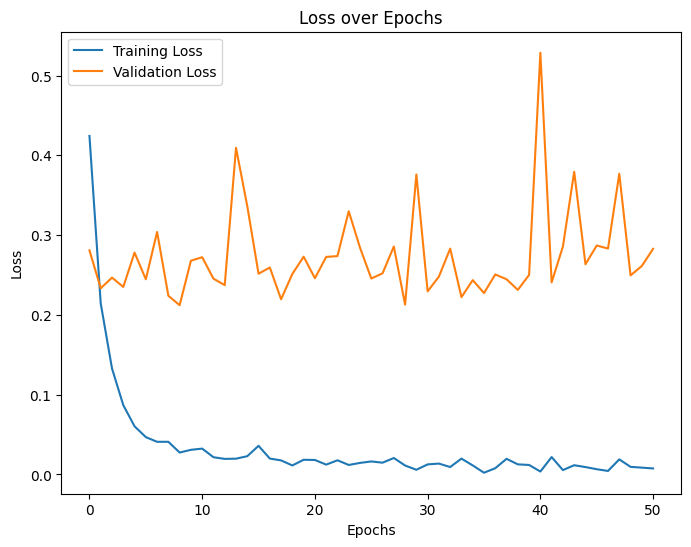

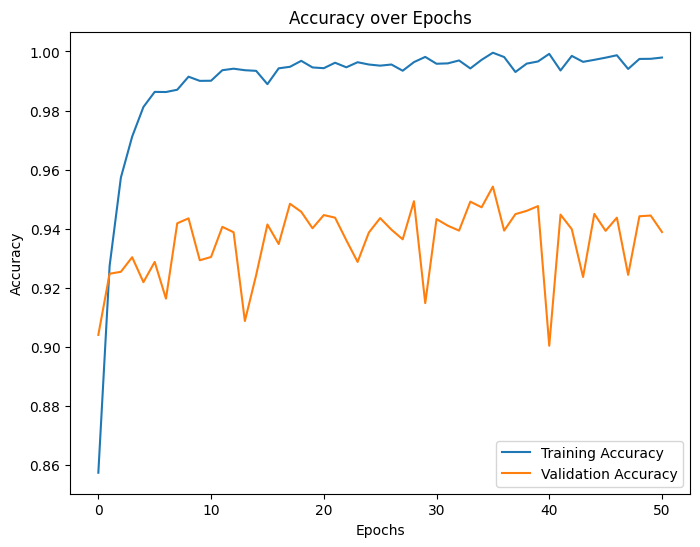

In [ ]:
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

729/729 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step


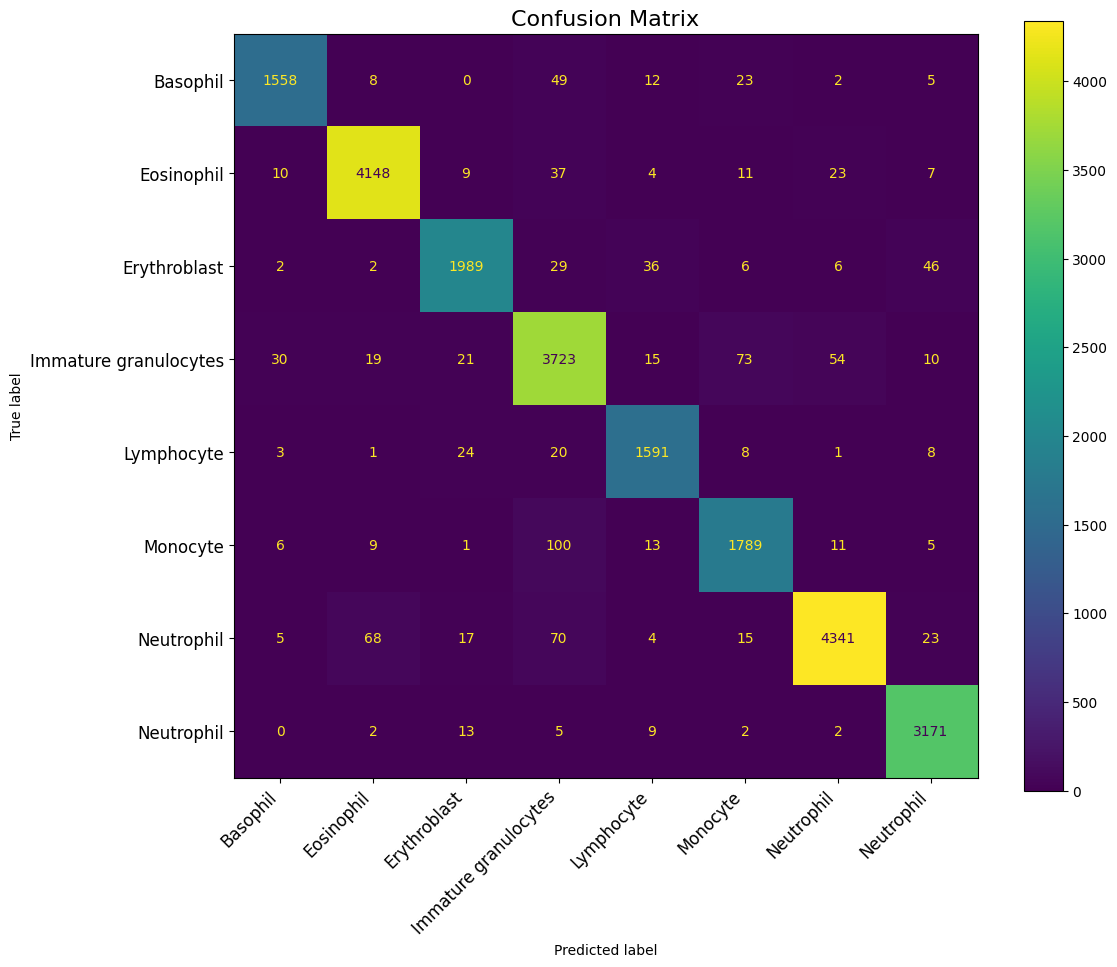

Accuracy: 95.73%


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

ft_model = tfk.models.load_model('TuningNAS.keras')

y_pred = ft_model.predict(x_train)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_train.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
class_labels = ["Basophil", "Eosinophil", "Erythroblast",
                "Immature granulocytes", "Lymphocyte",
                "Monocyte", "Neutrophil", "Neutrophil"]

# Visualizzazione con dimensioni e rotazioni personalizzate
fig, ax = plt.subplots(figsize=(12, 10))  # Aumenta le dimensioni della figura
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap="viridis", ax=ax)
plt.xticks(rotation=45, ha="right", fontsize=12)  # Rotazione e dimensione carattere delle etichette
plt.yticks(fontsize=12)  # Dimensione carattere etichette asse y
plt.title("Confusion Matrix", fontsize=16)
plt.show()

accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy:.2%}")

# **Duble class 5 - fake dataset**

As anticipated to solve the problem of class 5 classification (the one with the most errors) I modify the input dataset

# **Load Data**

In [ ]:
data = np.load('datasetWithout.npz')
#Load a second dataset where there are only class 5
data5 = np.load('images_with_labels.npz')

#Dataset for traing
x_train = data['x_train']
y_train = data['y_train']
#Dataset for validation
x_train2 = data['x_train']
y_train2 = data['y_train']
x_train_normal = data['x_train']
y_train_normal = data['y_train']

x5 = data5['images']
y5 = data5['labels']

#Reshape of label and concatenation. In this way I increased the data in dataset 5
x_train = np.concatenate((x_train, x5), axis=0)
y5 = y5.reshape(-1, 1)
y_train = np.concatenate((y_train, y5), axis=0)

In [ ]:
#Lowering the odds of class 3
quantity = 1000
class_to_duplicate = [0,1,2,4,5,7,6]
for i in class_to_duplicate:
    class_N_indices = np.where(y_train.flatten() == i)[0]
    images_N = x_train[class_N_indices][:quantity]
    labels_N = y_train[class_N_indices][:quantity]
    x_train = np.concatenate([x_train, images_N], axis=0)
    y_train = np.concatenate([y_train, labels_N], axis=0)

In [ ]:
#Normalization e categorization
x_train = x_train / 255.0
y_train = to_categorical(y_train).astype('float32')
x_train2 = x_train2 / 255.0
y_train2 = to_categorical(y_train2).astype('float32')
x_train_normal = x_train_normal / 255.0
y_train_normal = to_categorical(y_train_normal).astype('float32')

# **Class weight**
I calculate the weight of the classes as before

In [ ]:
if len(y_train.shape) > 1:
    y_train_m = np.argmax(y_train, axis=1)

class_counts = np.bincount(y_train_m)
total_samples = len(y_train_m)

class_weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts)}

# **Augmentation**
Same augmentation as before

In [ ]:
data_augmentation_traing = tfk.Sequential(
[
    keras_cv.layers.RandAugment(
        value_range=(0.0, 1.0),
        augmentations_per_image=4,
        magnitude_stddev=0.4,
        rate=0.5
    )
])

In [ ]:
data_augmentation_validation = keras_cv.layers.RandomAugmentationPipeline(
    layers=[
        keras_cv.layers.RandomTranslation(height_factor=0.5, width_factor=0.5, seed=seed),
        keras_cv.layers.RandomTranslation(height_factor=0.5, width_factor=0.5, seed=seed),
        keras_cv.layers.RandomContrast(factor=0.8, value_range=(0.0, 1.0), seed=seed),
        keras_cv.layers.RandomHue(factor=(0.8,1.0), value_range=(0.0, 1.0), seed=seed),
        keras_cv.layers.RandomSharpness(factor = 1, value_range=(0.0, 1.0), seed=seed),
        keras_cv.layers.RandomColorDegeneration(factor = 1, seed=seed),
        keras_cv.layers.ChannelShuffle(groups=3, seed=seed),
        keras_cv.layers.RandomChannelShift(factor=0.8, value_range=(0.0, 1.0), channels=3, seed=seed),
        keras_cv.layers.Solarization(value_range = (0.0, 1.0), seed=seed),
        keras_cv.layers.RandomBrightness(factor=0.3, value_range=(0.0, 1.0), seed=seed),
        keras_cv.layers.GridMask(ratio_factor=(0, 0.4), rotation_factor=0.2, fill_mode="constant", fill_value=0.0, seed=seed)
    ],
    seed=12,
    augmentations_per_image=4
)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(512)
train_dataset2 = tf.data.Dataset.from_tensor_slices((x_train2, y_train2)).batch(512)

In [ ]:
def augment_images(image, label):
    image = data_augmentation_traing(image)
    return image, label
train_dataset = train_dataset.map(augment_images, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
def augment_images2(image, label):
    image = data_augmentation_validation(image)
    return image, label
train_dataset2 = train_dataset2.map(augment_images2, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset2 = train_dataset2.prefetch(tf.data.AUTOTUNE)

In [ ]:
x_train, y_train = [], []
for batch in train_dataset:
    images = batch[0].numpy()
    labels = batch[1].numpy()
    x_train.append(images)
    y_train.append(labels)
x_train = np.concatenate(x_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

del train_dataset

In [ ]:
x_train2, y_train2 = [], []
for batch in train_dataset2:
    images2 = batch[0].numpy()
    labels2 = batch[1].numpy()
    x_train2.append(images2)
    y_train2.append(labels2)
x_train2 = np.concatenate(x_train2, axis=0)
y_train2 = np.concatenate(y_train2, axis=0)

del train_dataset2

In [ ]:
indices = np.random.permutation(len(x_train2))
x_val = x_train2[indices]
y_val = y_train2[indices]

In [ ]:
indices = np.random.permutation(len(x_train))
x_train = x_train[indices]
y_train = y_train[indices]

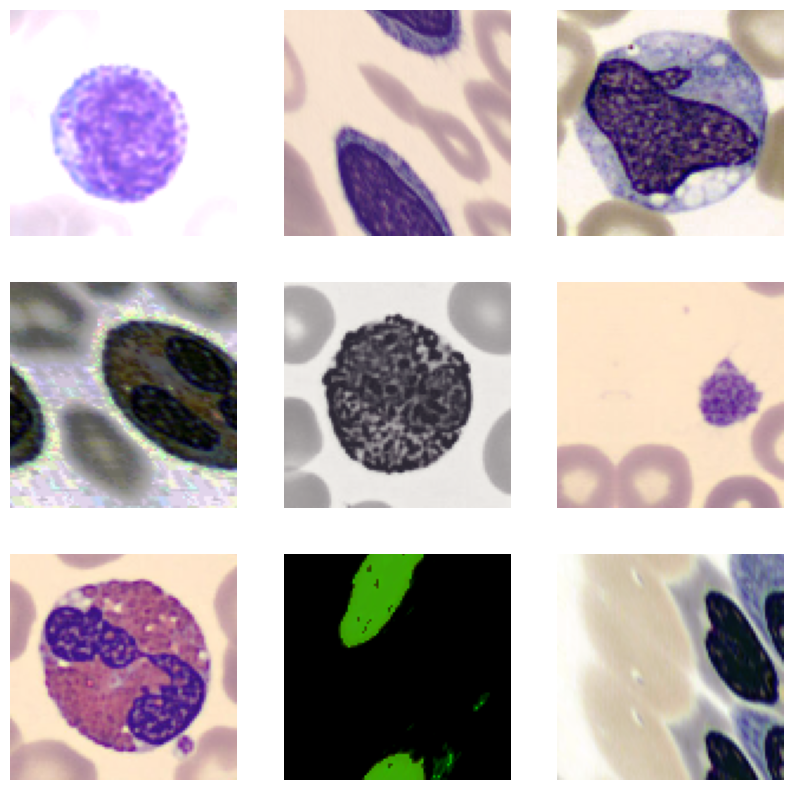

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
   plt.subplot(3, 3, i + 1)
   plt.imshow(x_train[i+7777])
   plt.axis("off")
plt.show()

# **Tuning learning  - Val_presion model - fake dataset**



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

ft_model = tfk.models.load_model('InceptionResNetV2.keras')

ft_model.get_layer('inception_resnet_v2').trainable = True

for layer in ft_model.get_layer('inception_resnet_v2').layers:
    layer.trainable = False

for i, layer in enumerate(ft_model.get_layer('inception_resnet_v2').layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True

In [ ]:
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy'])

In [ ]:
patience = 15

early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

callbacks = [early_stopping]

In [ ]:
history = ft_model.fit(
    x=x_train,
    y=y_train,
    batch_size = 32,
    epochs=1000,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    class_weight=class_weights
).history

ft_model.save("TuningFakeDB.keras")

Epoch 1/1000
622/622 ━━━━━━━━━━━━━━━━━━━━ 163s 145ms/step - accuracy: 0.7163 - loss: 0.8453 - val_accuracy: 0.6355 - val_loss: 1.2202
Epoch 2/1000
622/622 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.8942 - loss: 0.3155 - val_accuracy: 0.6634 - val_loss: 0.9494
Epoch 3/1000
622/622 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.9303 - loss: 0.2078 - val_accuracy: 0.6824 - val_loss: 1.0521
Epoch 4/1000
622/622 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.9579 - loss: 0.1283 - val_accuracy: 0.6840 - val_loss: 1.2508
Epoch 5/1000
622/622 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.9671 - loss: 0.1033 - val_accuracy: 0.6512 - val_loss: 1.4890
Epoch 6/1000
622/622 ━━━━━━━━━━━━━━━━━━━━ 38s 62ms/step - accuracy: 0.9742 - loss: 0.0816 - val_accuracy: 0.7202 - val_loss: 1.0073
Epoch 7/1000
622/622 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - accuracy: 0.9812 - loss: 0.0622 - val_accuracy: 0.7152 - val_loss: 1.2689
Epoch 8/1000
622/622 ━━━━━━━━━━━━━━━━━━━━ 38s 62ms/step - accuracy: 0.9817

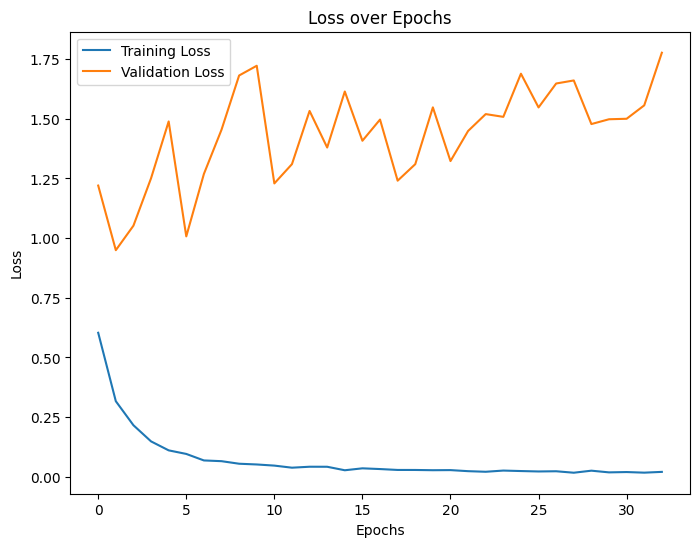

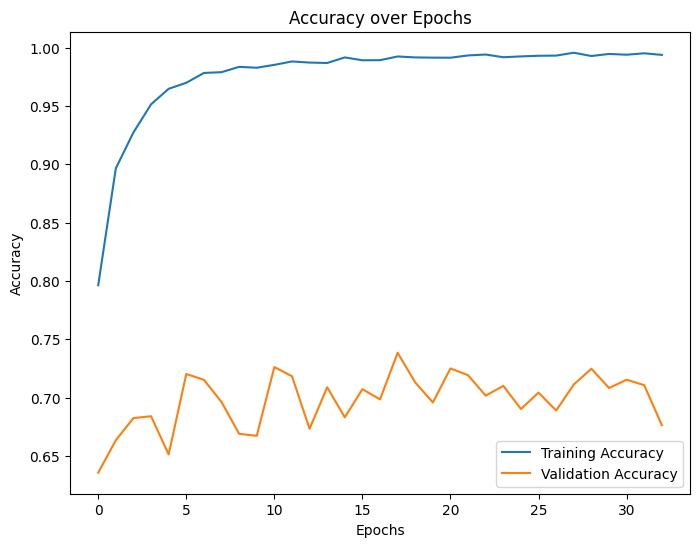

In [ ]:
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

622/622 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step


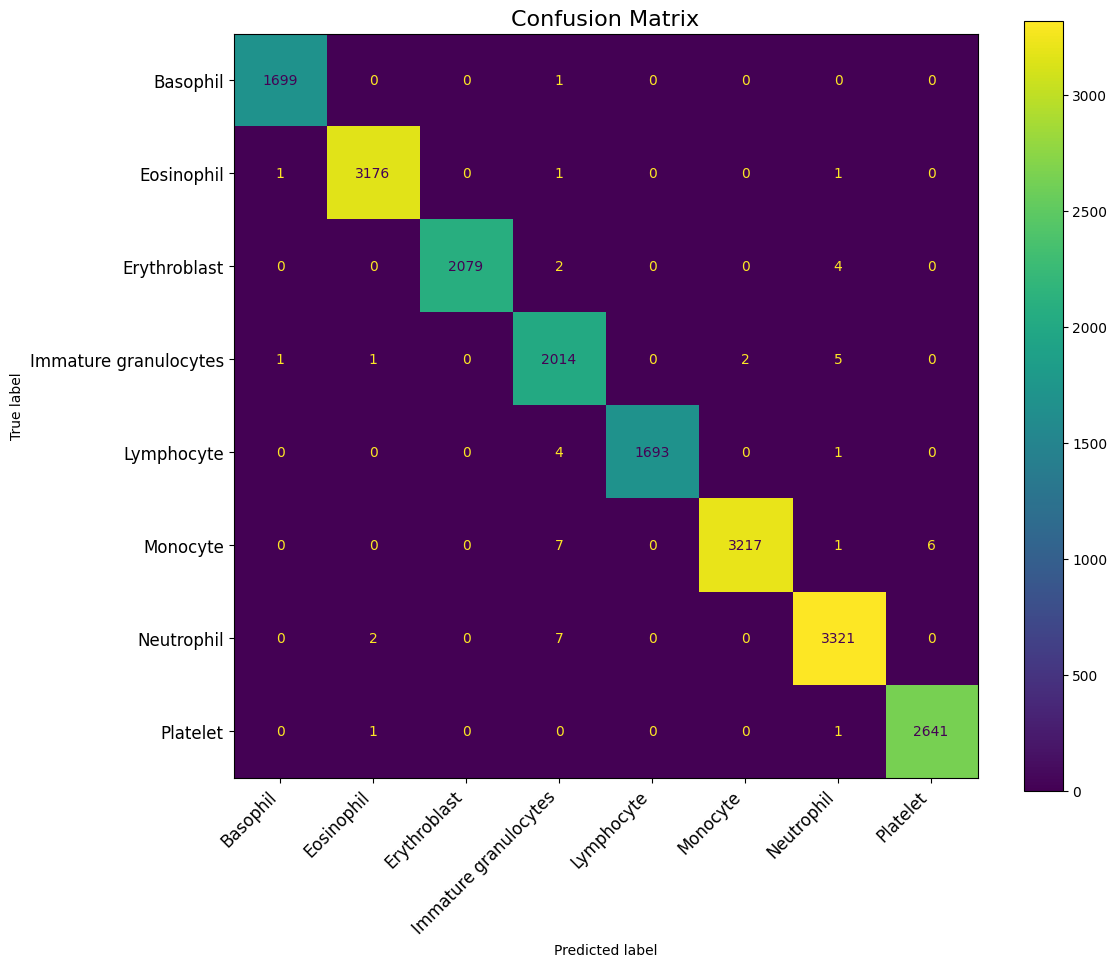

Accuracy: 99.75%


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

ft_model = tfk.models.load_model('TuningFakeDB.keras')

y_pred = ft_model.predict(x_train)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_train.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
class_labels = ["Basophil", "Eosinophil", "Erythroblast",
                "Immature granulocytes", "Lymphocyte",
                "Monocyte", "Neutrophil", "Platelet"]

fig, ax = plt.subplots(figsize=(12, 10))  # Aumenta le dimensioni della figura
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap="viridis", ax=ax)
plt.xticks(rotation=45, ha="right", fontsize=12)  # Rotazione e dimensione carattere delle etichette
plt.yticks(fontsize=12)  # Dimensione carattere etichette asse y
plt.title("Confusion Matrix", fontsize=16)
plt.show()

accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy:.2%}")

# Transfer and tuning with convNext

Last attempt at transfer learning with convnext. Unfortunately, in the training I ran out of computing capacity and never finished it. Network too heavy

# ***Transfer and tuning Model***

In [ ]:
#MOdel's parameter
input_shape = (96, 96, 3)
output_shape = 8
learning_rate = 0.005
batch_size = 32
epochs = 1000

In [ ]:
# @title ConvNeXtXLarge improt
NAS = tfk.applications.ConvNeXtXLarge(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    pooling='avg',
)

for layer in NAS.layers:
    layer.trainable = False

# Input layer
inputs = tfk.Input(shape=input_shape)

x = NAS(inputs)

# Dense layers (head of the model), with some moderate dropout + bachnormalization
x = tfkl.Dropout(0.3, name='dropout')(x)
x = tfkl.Dense(256, name="dense1")(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Activation("relu")(x)
x = tfkl.Dropout(0.4, name='dropout1')(x)
outputs = tfkl.Dense(output_shape, activation='softmax', name="output")(x)  # Final layer

# Compile the model
tl_model = tfk.Model(inputs=inputs, outputs=outputs)
tl_model.compile(
    loss=tfk.losses.CategoricalCrossentropy(),
    optimizer=tfk.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)
# Model summary
tl_model.summary(expand_nested=True)

1393257616/1393257616 ━━━━━━━━━━━━━━━━━━━━ 65s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ convnext_xlarge (Functional)         │ (None, 2048)                │     348,147,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer_1 (InputLayer)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 96, 96, 3)           │               0 │
│ convnext_xlarge_prestem_normalizati… │                             │                 │
│ (Normalization)                      │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ convnext_xlarge_stem            │ (None, 24, 24, 256)         │          13,056 │
│ (Sequential)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│       └ convnext_xlarge_stem_conv    │ (None, 24, 24, 256)         │          12,544 │
│ (Conv2D)                             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│       └                              │ (None, 24, 24, 256)         │             512 │
│ convnext_xlarge_stem_layernorm       │                             │                 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 24, 24, 256)         │          12,800 │
│ convnext_xlarge_stage_0_block_0_dep… │                             │                 │
│ (Conv2D)                             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 24, 24, 256)         │             512 │
│ convnext_xlarge_stage_0_block_0_lay… │                             │                 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 24, 24, 1024)        │         263,168 │
│ convnext_xlarge_stage_0_block_0_poi… │                             │                 │
│ (Dense)                              │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 24, 24, 1024)        │               0 │
│ convnext_xlarge_stage_0_block_0_gelu │                             │                 │
│ (Activation)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 24, 24, 256)         │         262,400 │
│ convnext_xlarge_stage_0_block_0_poi… │                             │                 │
│ (Dense)                              │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 24, 24, 256)         │             256 │
│ convnext_xlarge_stage_0_block_0_lay… │                             │              

 Total params: 348,675,592 (1.30 GB)

 Trainable params: 527,112 (2.01 MB)

 Non-trainable params: 348,148,480 (1.30 GB)

In [ ]:
# Define the patience value for early stopping
patience = 15

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)
#custom_lr_scheduler = CustomLearningRateScheduler(initial_lr=0.001, decay=0.95)

# Store the callback in a list
callbacks = [early_stopping]

In [ ]:
history = tl_model.fit(
    x=x_train,
    y=y_train,
    batch_size = 32,
    epochs=1000,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    class_weight=class_weights
).history

tl_model.save("TransferConvexLarge.keras")

Epoch 1/1000
622/622 ━━━━━━━━━━━━━━━━━━━━ 110s 128ms/step - accuracy: 0.2597 - loss: 2.1612 - val_accuracy: 0.3452 - val_loss: 1.8041
Epoch 2/1000
622/622 ━━━━━━━━━━━━━━━━━━━━ 50s 80ms/step - accuracy: 0.4622 - loss: 1.5263 - val_accuracy: 0.3828 - val_loss: 1.7203
Epoch 3/1000
622/622 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.5159 - loss: 1.3657 - val_accuracy: 0.3957 - val_loss: 1.6997
Epoch 4/1000
622/622 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.5574 - loss: 1.2594 - val_accuracy: 0.4080 - val_loss: 1.6739
Epoch 5/1000
622/622 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.5744 - loss: 1.1931 - val_accuracy: 0.4187 - val_loss: 1.6508
Epoch 6/1000
622/622 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.6003 - loss: 1.1214 - val_accuracy: 0.4286 - val_loss: 1.6411
Epoch 7/1000
622/622 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.6064 - loss: 1.1068 - val_accuracy: 0.4257 - val_loss: 1.6620
Epoch 8/1000
622/622 ━━━━━━━━━━━━━━━━━━━━ 50s 80ms/step - accuracy: 0.6232

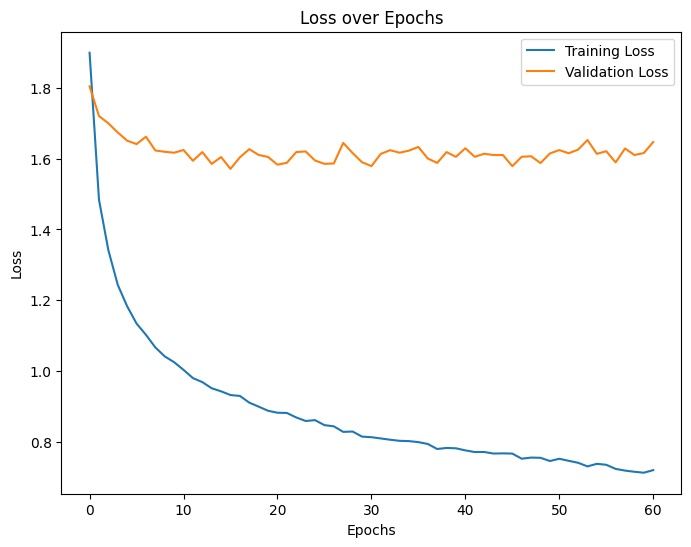

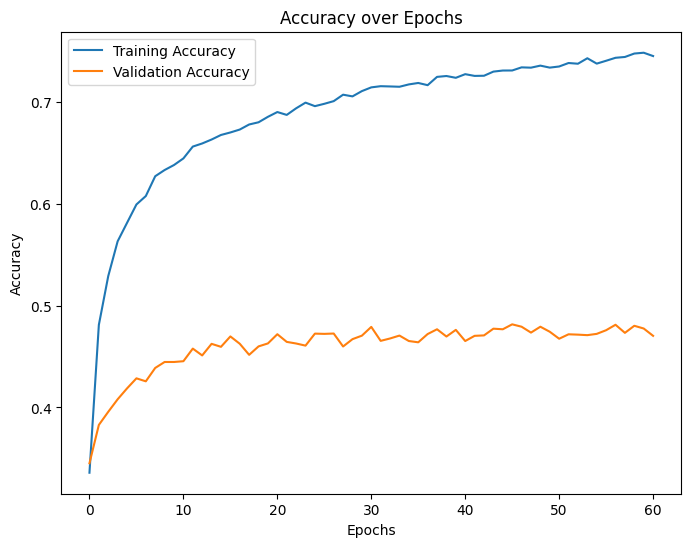

In [ ]:
# Estrarre i dati
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

# Crea un grafico per la perdita
plt.figure(figsize=(8, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Crea un grafico per l'accuratezza
plt.figure(figsize=(8, 6))
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

ft_model = tfk.models.load_model('TransferConvexLarge.keras')

ft_model.get_layer('convnext_xlarge').trainable = True

for layer in ft_model.get_layer('convnext_xlarge').layers:
    layer.trainable = False

for i, layer in enumerate(ft_model.get_layer('convnext_xlarge').layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True

In [ ]:
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy'])

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="TC.keras",
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1,
)

In [ ]:
patience = 15

early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

callbacks = [early_stopping, checkpoint]

In [ ]:
history = ft_model.fit(
    x=x_train,
    y=y_train,
    batch_size = 32,
    epochs=1000,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    class_weight=class_weights
).history

ft_model.save("TuningFakeDB.keras")

Epoch 1/1000
622/622 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7584 - loss: 0.6914
Epoch 1: val_accuracy improved from -inf to 0.57167, saving model to TC.keras
622/622 ━━━━━━━━━━━━━━━━━━━━ 171s 202ms/step - accuracy: 0.7584 - loss: 0.6913 - val_accuracy: 0.5717 - val_loss: 1.2863
Epoch 2/1000
622/622 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8327 - loss: 0.4917
Epoch 2: val_accuracy improved from 0.57167 to 0.59627, saving model to TC.keras
622/622 ━━━━━━━━━━━━━━━━━━━━ 96s 155ms/step - accuracy: 0.8327 - loss: 0.4917 - val_accuracy: 0.5963 - val_loss: 1.2681
Epoch 3/1000
622/622 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8602 - loss: 0.4099
Epoch 3: val_accuracy improved from 0.59627 to 0.61233, saving model to TC.keras
622/622 ━━━━━━━━━━━━━━━━━━━━ 97s 157ms/step - accuracy: 0.8602 - loss: 0.4099 - val_accuracy: 0.6123 - val_loss: 1.2058
Epoch 4/1000
622/622 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8787 - loss: 0.3487
Epoch 4: val_accuracy improved from 0.6